In [1]:
# This is a test script to verify the S2SVAE3 model can be used for inference.

import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')
import torch
from models.phrase_vae import load_t5_model_from_lit_ckpt
from models.vae_inference import PhraseVAE


model = PhraseVAE()

/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Check special token
encoded = model.encode_batch(['[INST]', '[SEP]'], do_sample=False,)
print(encoded.shape)
recon = model.decode_batch(encoded.unsqueeze(1))
print(recon)

inst_pad_latent = encoded[0]
eos_pad_latent = encoded[1]

save_dir = '/home/longshen/work/AccGen/AccGen/models'
save_fn = 'phr_vae_special_latents.pt'
res = {
    'inst_pad_latent': inst_pad_latent,
    'eos_pad_latent': eos_pad_latent,
}
torch.save(res, os.path.join(save_dir, save_fn))
print(f"Saved special token latents to {os.path.join(save_dir, save_fn)}")

torch.Size([2, 64])
['[BOS] [INST] [EOS]', '[BOS] [SEP] [EOS]']
Saved special token latents to /home/longshen/work/AccGen/AccGen/models/phr_vae_special_latents.pt


In [2]:
# Prepare data
from sonata_utils import read_jsonl
from remi_z import MultiTrack
midi_fp = '/data1/longshen/Datasets/Piano/POP909/pop909_longshen/data_key_normed/001/001.mid'

mt = MultiTrack.from_midi(midi_fp)
bar = mt[0]
phrase_1 = bar.tracks[0]
phrase_2 = bar.tracks[25]

phr1_str = phrase_1.to_remiz_str()
phr2_str = phrase_2.to_remiz_str()
print(phr1_str)
print(phr2_str)



i-0 o-0 p-41 d-18 o-3 p-48 d-15 o-6 p-53 d-9 o-9 p-60 d-15 o-24 p-43 d-15 o-27 p-50 d-12 o-30 p-55 d-12 o-33 p-59 d-9
i-25 o-0 p-69 d-6 o-6 p-67 d-3 o-12 p-65 d-3 o-18 p-74 d-3 o-21 p-76 d-3 o-24 p-74 d-15 o-42 p-60 d-3


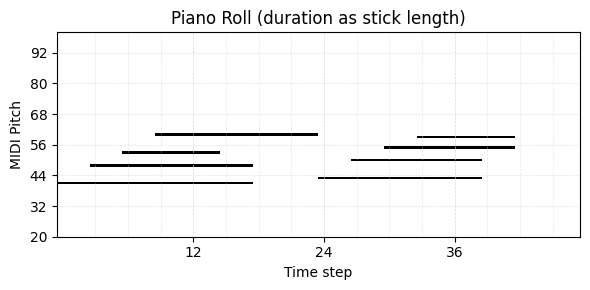

In [3]:
# Draw the two bars
from piano_roll_utils import save_piano_roll
from remi_z import MultiTrack

phr1_mt = MultiTrack.from_midi(midi_fp)
phr1_mt.filter_tracks(insts=[0])
phr2_mt = MultiTrack.from_midi(midi_fp)
phr2_mt.filter_tracks(insts=[25])

proll1 = phr1_mt[0].to_piano_roll(pos_per_bar=48)
save_piano_roll(proll1, 'phr1.png', show=True)

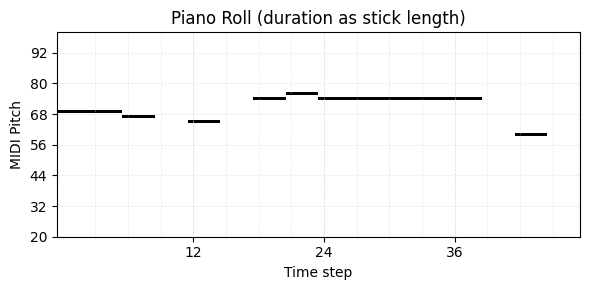

In [4]:
proll2 = phr2_mt[0].to_piano_roll(pos_per_bar=48)
save_piano_roll(proll2, 'phr2.png', show=True)  

In [5]:
latents = model.encode_batch([phr1_str, phr2_str], do_sample=False)
print(latents.shape)

torch.Size([2, 64])


In [6]:
from sonata_utils import jpath, create_dir_if_not_exist

# Check piano roll reconstruction
recon_str = model.decode_batch(latents.unsqueeze(1))
print(recon_str[0])
print(recon_str[1])
decoded = model.decode_batch(latents.unsqueeze(1))
print(decoded[0])
print(decoded[1])

# proll1_rec = recon_mts[0][0].to_piano_roll(pos_per_bar=48)
# proll2_rec = recon_mts[1][0].to_piano_roll(pos_per_bar=48)
# bar1_rec = recon_mts[0]
# bar2_rec = recon_mts[1]

# save_piano_roll(proll1_rec, 'bar1_rec.png', show=True)
# save_dir = '/data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt'
# save_fp = jpath(save_dir, 'bar1_recon.mid')
# bar1_rec.to_midi(save_fp, tempo=90)

[BOS] i-0 o-0 p-41 d-18 o-3 p-48 d-15 o-6 p-53 d-9 o-9 p-60 d-15 o-24 p-43 d-15 o-27 p-50 d-12 o-30 p-55 d-12 o-33 p-59 d-9 [EOS]
[BOS] i-25 o-0 p-69 d-6 o-6 p-67 d-3 o-12 p-65 d-3 o-18 p-74 d-3 o-21 p-76 d-3 o-24 p-74 d-15 o-42 p-60 d-3 [EOS] [PAD] [PAD] [PAD]
[BOS] i-0 o-0 p-41 d-18 o-3 p-48 d-15 o-6 p-53 d-9 o-9 p-60 d-15 o-24 p-43 d-15 o-27 p-50 d-12 o-30 p-55 d-12 o-33 p-59 d-9 [EOS]
[BOS] i-25 o-0 p-69 d-6 o-6 p-67 d-3 o-12 p-65 d-3 o-18 p-74 d-3 o-21 p-76 d-3 o-24 p-74 d-15 o-42 p-60 d-3 [EOS] [PAD] [PAD] [PAD]


In [7]:
# Check special token
encoded = model.encode_batch(['[INST]', 'b-1'], do_sample=False)
print(encoded.shape)
recon = model.decode_batch(encoded.unsqueeze(1))
print(recon)

torch.Size([2, 64])
['[BOS] [INST] [EOS]', '[BOS] b-1 [EOS]']


In [10]:
# Weighted interpolation
save_dir = '/data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate'
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
interp_dir = jpath(save_dir, 'interp')
proll_save_dir = jpath(interp_dir, 'prolls')
os.makedirs(proll_save_dir, exist_ok=True)
latents1 = latents[0:1]
latents2 = latents[1:2]
for w in weights:
    latents_interp = (1-w) * latents1 + w * latents2
    decoded = model.decode_batch(latents_interp.unsqueeze(1))
    mt_interp = MultiTrack.from_remiz_str(decoded[0])[0]
    proll_interp = mt_interp.to_piano_roll(pos_per_bar=48)
    proll_fp = jpath(proll_save_dir, f'bar_interp_w{w:.1f}.png')
    save_piano_roll(proll_interp, proll_fp, show=False)
    midi_fp = jpath(interp_dir, f'bar_interp_w{w:.1f}.mid')
    mt_interp.to_midi(midi_fp, tempo=90)

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.0.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.1.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.2.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.3.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.4.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.5.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/interpolate/interp/bar_interp_w0.6.mid
MIDI file suc

In [6]:
# Sample directly
from sonata_utils import create_dir_if_not_exist
from piano_roll_utils import save_piano_roll
jpath = os.path.join
save_dir = '/data1/longshen/Results/AccGenResults/test_outputs/vae/phrase_level/prior_sampling'
sample_save_dir = jpath(save_dir, '0.5std')
create_dir_if_not_exist(sample_save_dir)
z_random = torch.randn(10, 1, 64)
# scale_factor = 0.7590118646621704
scale_factor = 0.5
z_random = z_random * scale_factor

decoded = model.decode_batch(z_random)
mts = [MultiTrack.from_remiz_str(s) for s in decoded]
for i, mt in enumerate(mts):
    proll = mt[0].to_piano_roll(pos_per_bar=48)
    save_piano_roll(proll, jpath(sample_save_dir, f'bar_sample_{i}.png'))
    save_fp = jpath(sample_save_dir, f'bar_sample_{i}.mid')
    mt.to_midi(save_fp, tempo=90, verbose=False)